# CAMS - Data
Process is similar in ERA5-Reanalysis
We use two .nc files. One contains data about PM2.5,PM10,CO,NO2 and the other information about NO,O3,SO2

In [1]:
import pygrib
import xarray as xr

In [2]:
DS = xr.open_dataset('./CAMS/PMCONO2-201904-202203.nc')
DS1 = xr.open_dataset('./CAMS/DustNOO3SO2-201904-202203.nc')

In [3]:
#GET DATES

from datetime import date, timedelta

start_date = date(2019, 4, 1) 
end_date = date(2022, 3, 31)    # perhaps date.now()

delta = end_date - start_date   # returns timedelta

dates = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    dates.append(day)

## Prefecture Analysis

In [5]:
import cartopy.io.shapereader as shpreader
import shapely.vectorized
import pandas as pd
import numpy as np

periferies = './CAMS/shp1/PERIFEREIES_ELLADAS.shp'
reader = shpreader.Reader(periferies)
records = list(reader.records())

df = pd.DataFrame([entry.attributes for entry in records])

name_temp= 'LEKTIKO'

In [6]:
df['LEKTIKO']

0     ΠΕΡΙΦΕΡΕΙΑ ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ ΚΑΙ ΘΡΑΚΗΣ
1                 ΠΕΡΙΦΕΡΕΙΑ ΚΕΝΤΡΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ
2                   ΠΕΡΙΦΕΡΕΙΑ ΔΥΤΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ
3                              ΠΕΡΙΦΕΡΕΙΑ ΗΠΕΙΡΟΥ
4                            ΠΕΡΙΦΕΡΕΙΑ ΘΕΣΣΑΛΙΑΣ
5                      ΠΕΡΙΦΕΡΕΙΑ ΣΤΕΡΕΑΣ ΕΛΛΑΔΑΣ
6                         ΠΕΡΙΦΕΡΕΙΑ ΙΟΝΙΩΝ ΝΗΣΩΝ
7                      ΠΕΡΙΦΕΡΕΙΑ ΔΥΤΙΚΗΣ ΕΛΛΑΔΑΣ
8                         ΠΕΡΙΦΕΡΕΙΑ ΠΕΛΟΠΟΝΝΗΣΟΥ
9                              ΠΕΡΙΦΕΡΕΙΑ ΑΤΤΙΚΗΣ
10                     ΠΕΡΙΦΕΡΕΙΑ ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ
11                      ΠΕΡΙΦΕΡΕΙΑ ΝΟΤΙΟΥ ΑΙΓΑΙΟΥ
12                              ΠΕΡΙΦΕΡΕΙΑ ΚΡΗΤΗΣ
13                       Άγιο Όρος (Αυτοδιοίκητο)
Name: LEKTIKO, dtype: object

In [10]:
ds=DS

### pm10 , co , no2 , pm2.5 

In [11]:
from itertools import product, cycle
points =list(product(ds.latitude.values, ds.longitude.values))
x = [i for j, i in points]
y = [j for j, i in points]

In [12]:
#From the above cell
NAME_ATTR = name_temp

#x has latitude , y has longitude
masked_data=None
mask_array=None
totalData=[]
for index, region in enumerate(records):
    
    mask = shapely.vectorized.contains(region.geometry, x, y).reshape(
        (ds.latitude.shape[0], ds.longitude.shape[0]))
    #mask = shapely.vectorized.contains(region.geometry, x, y)
    if np.any(mask):
        print("Processing {region}".format(region=region.attributes[NAME_ATTR]))
        mask_array = xr.DataArray(mask, dims=('latitude', 'longitude'),
                                      coords={'longitude': ds.longitude, 'latitude': ds.latitude})
        #print(mask_array)
        
        #masked_data = ds.mean(dim='time').where(mask_array, drop=True)
        masked_data = ds.where(mask_array,drop=True)
        totalData.append((region,masked_data))
    else:
        print("{region} does not intersect AOI".format(region=region.attributes[NAME_ATTR]))

Processing ΠΕΡΙΦΕΡΕΙΑ ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ ΚΑΙ ΘΡΑΚΗΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΚΕΝΤΡΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΔΥΤΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΗΠΕΙΡΟΥ
Processing ΠΕΡΙΦΕΡΕΙΑ ΘΕΣΣΑΛΙΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΣΤΕΡΕΑΣ ΕΛΛΑΔΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΙΟΝΙΩΝ ΝΗΣΩΝ
Processing ΠΕΡΙΦΕΡΕΙΑ ΔΥΤΙΚΗΣ ΕΛΛΑΔΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΠΕΛΟΠΟΝΝΗΣΟΥ
Processing ΠΕΡΙΦΕΡΕΙΑ ΑΤΤΙΚΗΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ
Processing ΠΕΡΙΦΕΡΕΙΑ ΝΟΤΙΟΥ ΑΙΓΑΙΟΥ
Processing ΠΕΡΙΦΕΡΕΙΑ ΚΡΗΤΗΣ
Processing Άγιο Όρος (Αυτοδιοίκητο)


In [13]:
def calculateMetrics(totalData,VARIABLES):
    dataFrames = []
    for region,data in totalData[0:]:
        #Initialize dataframe
        poli = [region.attributes[NAME_ATTR] for i in range(len(dates))]
        df = pd.DataFrame(dates,columns=['Date'])
        #df['Date']=dates
        df['City']=poli
        
        for VARIABLE in VARIABLES:
            arr = data[VARIABLE].values
            mean = []
            median = []
            average = []
            var = []
            poli=[]
            for idx,dailyMetrics in enumerate(arr):
                flattenedMetrics = dailyMetrics.flatten()

                #Remove nan values from np.array
                flattenedMetrics = flattenedMetrics[~np.isnan(flattenedMetrics)]
                mean.append(np.mean(flattenedMetrics))
                median.append( np.median(flattenedMetrics))
                average.append( np.average(flattenedMetrics))
                var.append(np.var(flattenedMetrics))
                poli.append(region.attributes[NAME_ATTR])
            
            #cut _conc
            newVar = VARIABLE.replace("_conc","")
            df[newVar+'_mean']=mean
            df[newVar+'_average']=average
            df[newVar+'_median'] = median
            df[newVar+'_var']=var
            #df = pd.DataFrame(list(zip(poli,dates,mean,median,average,var)),columns=['City','Date',VARIABLE+'_mean',VARIABLE+'_median',VARIABLE+'_average',VARIABLE+'_var'])
        dataFrames.append(df)
    return dataFrames

In [14]:
VARIABLES = ['pm10_conc','co_conc','no2_conc','pm2p5_conc']
dfList_Periferies= calculateMetrics(totalData,VARIABLES)

In [42]:
#sample output of first 3 rows of a dataframe
for df in dfList_Periferies:
    print(df.head(3))
    break

         Date                                         City  pm10_mean  \
0  2019-04-01  ΠΕΡΙΦΕΡΕΙΑ ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ ΚΑΙ ΘΡΑΚΗΣ  15.577731   
1  2019-04-02  ΠΕΡΙΦΕΡΕΙΑ ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ ΚΑΙ ΘΡΑΚΗΣ  12.699450   
2  2019-04-03  ΠΕΡΙΦΕΡΕΙΑ ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ ΚΑΙ ΘΡΑΚΗΣ   9.428416   

   pm10_average  pm10_median   pm10_var     co_mean  co_average   co_median  \
0     15.577731    13.999819  12.782141  161.625977  161.625977  150.008789   
1     12.699450    12.061706  20.612165  157.021042  157.021042  155.630463   
2      9.428416     8.360649   7.271677  160.959869  160.959869  160.418152   

       co_var  no2_mean  no2_average  no2_median   no2_var  pm2p5_mean  \
0  489.142822  1.069571     1.069571    0.915051  0.332606   11.499238   
1   59.781433  1.048398     1.048398    0.909026  0.196624    9.482608   
2   14.954876  1.111617     1.111617    1.041610  0.198675    7.116020   

   pm2p5_average  pm2p5_median  pm2p5_var  
0      11.499238     10.555052   7.502330  
1    

### NO , O3 , SO2

In [16]:
VARIABLES1 = ['no_conc','o3_conc','so2_conc']

In [18]:
ds=DS1
points = list(product(ds.latitude.values, ds.longitude.values))
x = [i for j, i in points]
y = [j for j, i in points]

In [19]:
#From the above cell
NAME_ATTR = name_temp

#x has latitude , y has longitude
masked_data=None
mask_array=None
totalData=[]
for index, region in enumerate(records):
    
    mask = shapely.vectorized.contains(region.geometry, x, y).reshape(
        (ds.latitude.shape[0], ds.longitude.shape[0]))
    #mask = shapely.vectorized.contains(region.geometry, x, y)
    if np.any(mask):
        print("Processing {region}".format(region=region.attributes[NAME_ATTR]))
        mask_array = xr.DataArray(mask, dims=('latitude', 'longitude'),
                                      coords={'longitude': ds.longitude, 'latitude': ds.latitude})

        masked_data = ds.where(mask_array,drop=True)
        totalData.append((region,masked_data))
    else:
        print("{region} does not intersect AOI".format(region=region.attributes[NAME_ATTR]))

Processing ΠΕΡΙΦΕΡΕΙΑ ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ ΚΑΙ ΘΡΑΚΗΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΚΕΝΤΡΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΔΥΤΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΗΠΕΙΡΟΥ
Processing ΠΕΡΙΦΕΡΕΙΑ ΘΕΣΣΑΛΙΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΣΤΕΡΕΑΣ ΕΛΛΑΔΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΙΟΝΙΩΝ ΝΗΣΩΝ
Processing ΠΕΡΙΦΕΡΕΙΑ ΔΥΤΙΚΗΣ ΕΛΛΑΔΑΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΠΕΛΟΠΟΝΝΗΣΟΥ
Processing ΠΕΡΙΦΕΡΕΙΑ ΑΤΤΙΚΗΣ
Processing ΠΕΡΙΦΕΡΕΙΑ ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ
Processing ΠΕΡΙΦΕΡΕΙΑ ΝΟΤΙΟΥ ΑΙΓΑΙΟΥ
Processing ΠΕΡΙΦΕΡΕΙΑ ΚΡΗΤΗΣ
Processing Άγιο Όρος (Αυτοδιοίκητο)


In [20]:
dfList_Periferies_New = calculateMetrics(totalData,VARIABLES1)

### Dataframe merge and Export csvs - Prefecture

In [21]:
newDf_Periferies=[]
for i in range(len(dfList_Periferies_New)):
    df1=dfList_Periferies[i]
    df=dfList_Periferies_New[i]
    newDf_Periferies.append( pd.concat([df1.reset_index(drop=True),df.drop(['Date','City'],axis=1).reset_index(drop=True)], axis=1))

In [ ]:
#Export .csvs

for index, region in enumerate(records):
    print(newDf_Periferies[index].head(3))
    newDf_Periferies[index].to_csv('E:/CovidData/CAMS/data/'+region.attributes[NAME_ATTR]+'.csv',index=False)
    print(region.attributes[NAME_ATTR])

## Urban Areas Analysis

In [27]:
ASTIKES_PERIOXES = './CAMS/ASTIKES_PERIOXES/ASTIKES_PERIOXES.shp'
reader = shpreader.Reader(ASTIKES_PERIOXES)
records = list(reader.records())

df = pd.DataFrame([entry.attributes for entry in records])

name_temp= 'NAME'

for rec in records:
    lista = list(rec.attributes.keys())
    name_temp = lista[0]
    break


In [28]:
# All Areas of interest in the shapefile
df

,ΝΑΜΕ
0,LARISA
1,TRIKALA
2,KARDITSA
3,VOLOS
4,KATERINH
5,GIANNITSA
6,VEROIA
7,SERRES
8,KILKIS
9,EDESSA


### pm10 , co , no2 , pm2.5 

In [29]:
from itertools import product, cycle
ds=DS
points = list(product(ds.latitude.values, ds.longitude.values))
x = [i for j, i in points]
y = [j for j, i in points]

In [ ]:

NAME_ATTR = name_temp
ds=DS
#x has latitude , y has longitude
masked_data=None
mask_array=None
totalData=[]
for index, region in enumerate(records):

        
    poly = region.geometry
    dist=[]
    
    for (j,i) in points:
        coords = [(i,j)]
        pnt2 = shapely.geometry.MultiPoint(coords)
        distance = poly.distance(pnt2)
        
        if distance<=0.1:
            dist.append(((j,i),distance))
    newDist = dist
    
    coords=[]
    for ((x1,y1),distance) in newDist:
        coords.append([y1,x1])

    aoi = shapely.geometry.MultiPoint(coords)


    mask = shapely.vectorized.contains(aoi, x, y).reshape(
        (ds.latitude.shape[0], ds.longitude.shape[0]))
    
    flattened = shapely.vectorized.contains(aoi, x, y)
    
    print(region.attributes[NAME_ATTR]," ",coords)
    
    if np.any(mask):
        print("Processing {region}".format(region=region.attributes[NAME_ATTR]))
        mask_array = xr.DataArray(mask, dims=('latitude', 'longitude'),
                                      coords={'longitude': ds.longitude, 'latitude': ds.latitude})
        masked_data = ds.where(mask_array,drop=True)
        totalData.append((region,masked_data))
    else:
        print("{region} does not intersect AOI".format(region=region.attributes[NAME_ATTR]))

In [31]:
# dfList_Urban1 now contains PM10,PM2.5,NO2,CO information for EVERY urban area 

VARIABLES = ['pm10_conc','co_conc','no2_conc','pm2p5_conc']
dfList_Urban1= calculateMetrics(totalData,VARIABLES)

### NO , O3 , SO2

In [33]:
DS1 = xr.open_dataset('./CAMS/DustNOO3SO2-201904-202203.nc')
VARIABLES1 = ['no_conc','o3_conc','so2_conc']


In [34]:
ds=DS1
points = list(product(ds.latitude.values, ds.longitude.values))
x = [i for j, i in points]
y = [j for j, i in points]

In [ ]:
NAME_ATTR = name_temp
#x has latitude , y has longitude
masked_data=None
mask_array=None
totalData=[]
for index, region in enumerate(records):

        
    poly = region.geometry
    dist=[]
    
    for (j,i) in points:
        coords = [(i,j)]
        pnt2 = shapely.geometry.MultiPoint(coords)
        distance = poly.distance(pnt2)
        
        if distance<=0.1:
            dist.append(((j,i),distance))
    newDist = dist
    
    coords=[]
    for ((x1,y1),distance) in newDist:
        coords.append([y1,x1])

    aoi = shapely.geometry.MultiPoint(coords)


    mask = shapely.vectorized.contains(aoi, x, y).reshape(
        (ds.latitude.shape[0], ds.longitude.shape[0]))
    
    flattened = shapely.vectorized.contains(aoi, x, y)
    
    print(region.attributes[NAME_ATTR]," ",coords)
    
    if np.any(mask):
        print("Processing {region}".format(region=region.attributes[NAME_ATTR]))
        mask_array = xr.DataArray(mask, dims=('latitude', 'longitude'),
                                      coords={'longitude': ds.longitude, 'latitude': ds.latitude})
        masked_data = ds.where(mask_array,drop=True)
        totalData.append((region,masked_data))
    else:
        print("{region} does not intersect AOI".format(region=region.attributes[NAME_ATTR]))

In [36]:
dfList_Urban2 = calculateMetrics(totalData,VARIABLES1)
# dfList_Urban2 now contains NO,O3,SO2 information for EVERY urban area 

### Dataframe Merge and Export CSVs - Urban Areas

In [38]:
newDf=[]
for i in range(len(dfList_Urban1)):
    df1=dfList_Urban1[i]
    df=dfList_Urban2[i]
    newDf.append( pd.concat([df1.reset_index(drop=True),df.drop(['Date','City'],axis=1).reset_index(drop=True)], axis=1))
    

In [39]:
for index, region in enumerate(records):
    newDf[index].to_csv('E:/CovidData/CAMS/data/UrbanAreas/'+region.attributes[NAME_ATTR]+'.csv',index=False)
    print(region.attributes[NAME_ATTR])

LARISA
TRIKALA
KARDITSA
VOLOS
KATERINH
GIANNITSA
VEROIA
SERRES
KILKIS
EDESSA
KALAMPAKA
ELASSONA
NAOUSA
SOFADES
ORAIOKASTRO
PERAIA
THESSALONIKI
TIRNAVOS
NIKAIA
PYLI


In [78]:
import matplotlib.pyplot as plt
#import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

In [89]:
shpFile_gpd = gpd.read_file('./CAMS/ASTIKES_PERIOXES/ASTIKES_PERIOXES.shp')
prefecture_gpd = gpd.read_file('./CAMS/shp/prefecture.shp')

C:\Users\razkey\Anaconda3\envs\s5p\lib\site-packages\geopandas\plotting.py:637: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


<AxesSubplot:>

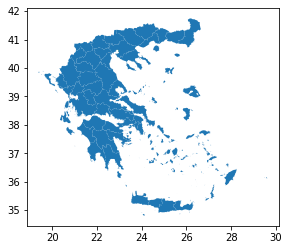

In [93]:
bdry_line = gpd.GeoDataFrame.from_file('./CAMS/ASTIKES_PERIOXES/ASTIKES_PERIOXES.shp')    
myploygons = gpd.GeoDataFrame.from_file('./CAMS/shp/prefecture.shp') 
ax = bdry_line.plot(color='yellow')
myploygons.plot(axes=ax,figsize=(15,15))

C:\Users\razkey\Anaconda3\envs\s5p\lib\site-packages\geopandas\plotting.py:637: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,
C:\Users\razkey\Anaconda3\envs\s5p\lib\site-packages\geopandas\plotting.py:637: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


<AxesSubplot:>

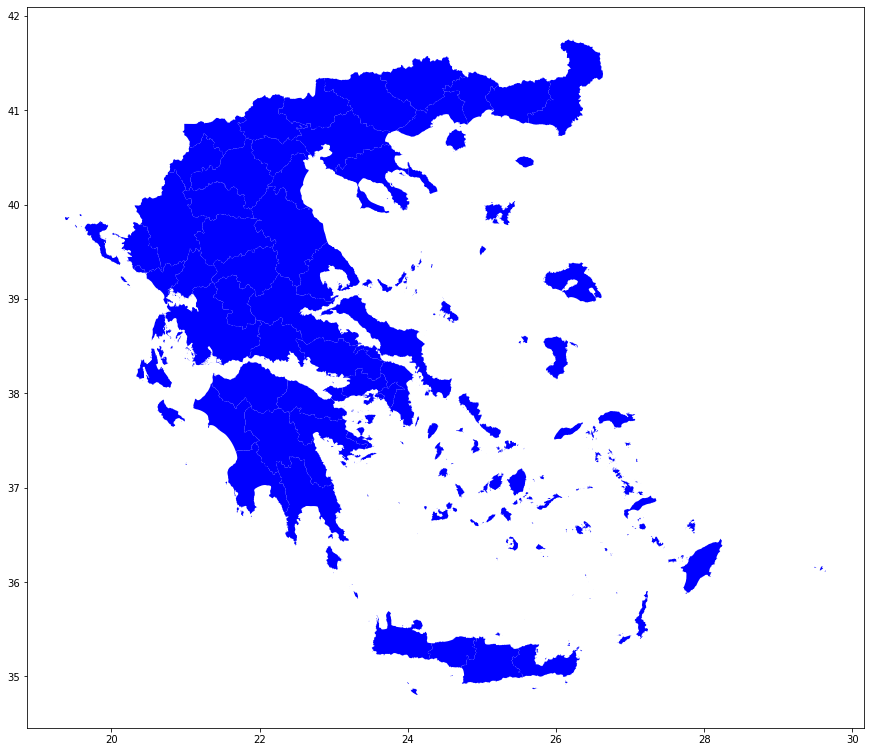

In [101]:
fig,ax = plt.subplots(figsize=(15,15))
bdry_line.plot(axes=ax,color='green')
myploygons.plot(axes=ax,color='blue')

C:\Users\razkey\Anaconda3\envs\s5p\lib\site-packages\geopandas\plotting.py:637: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


<AxesSubplot:>

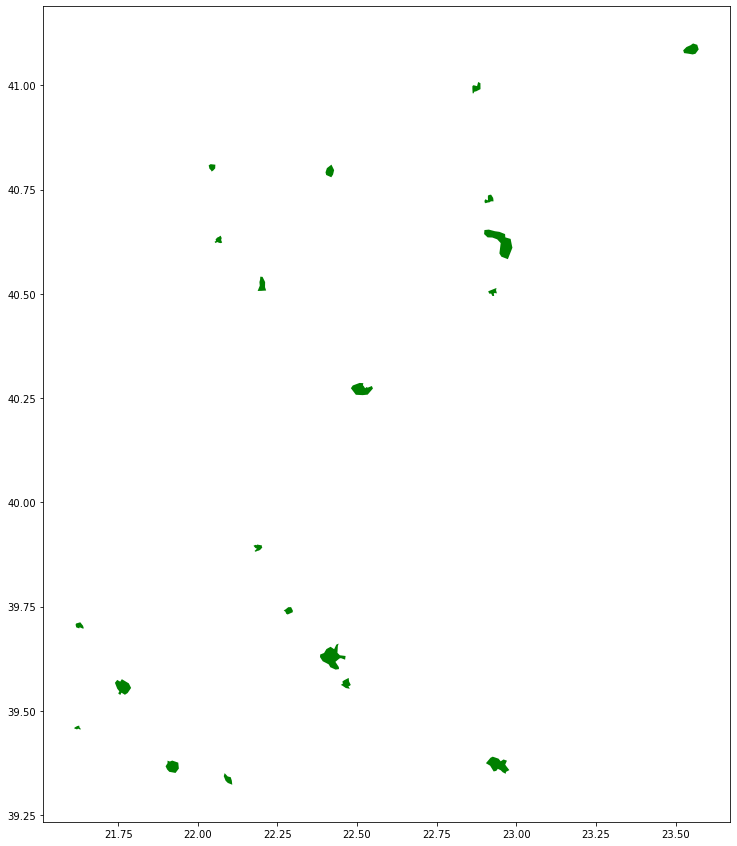

In [99]:
fig,ax = plt.subplots(figsize=(15,15))
bdry_line.plot(axes=ax,color='green')
#myploygons.plot(axes=ax,color='blue')

<AxesSubplot:>

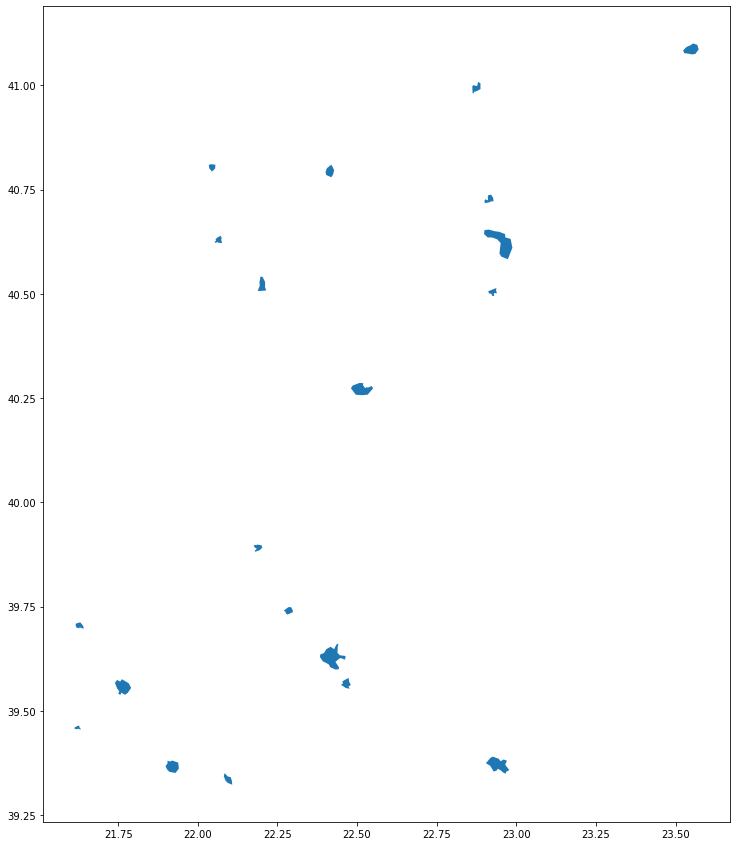

In [80]:
fig,ax = plt.subplots(figsize=(15,15))
shpFile.plot(ax=ax)

In [81]:
points = list(product(DS.longitude.values, DS.latitude.values))

In [82]:
geometry = [Point(xy) for xy in zip(ds.longitude.values,ds.latitude.values)]
geometry[:3]
crs={'init':'epsg:4326'}
df = pd.DataFrame()

In [83]:
#geometry = [Point(xy) for (x,y) in points] 
geom =[]
for (x,y) in points:
    geom.append(Point(x,y))

In [84]:
geo_df = gpd.GeoDataFrame(df,crs=crs,geometry=geom)

C:\Users\razkey\Anaconda3\envs\s5p\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
geom

<AxesSubplot:>

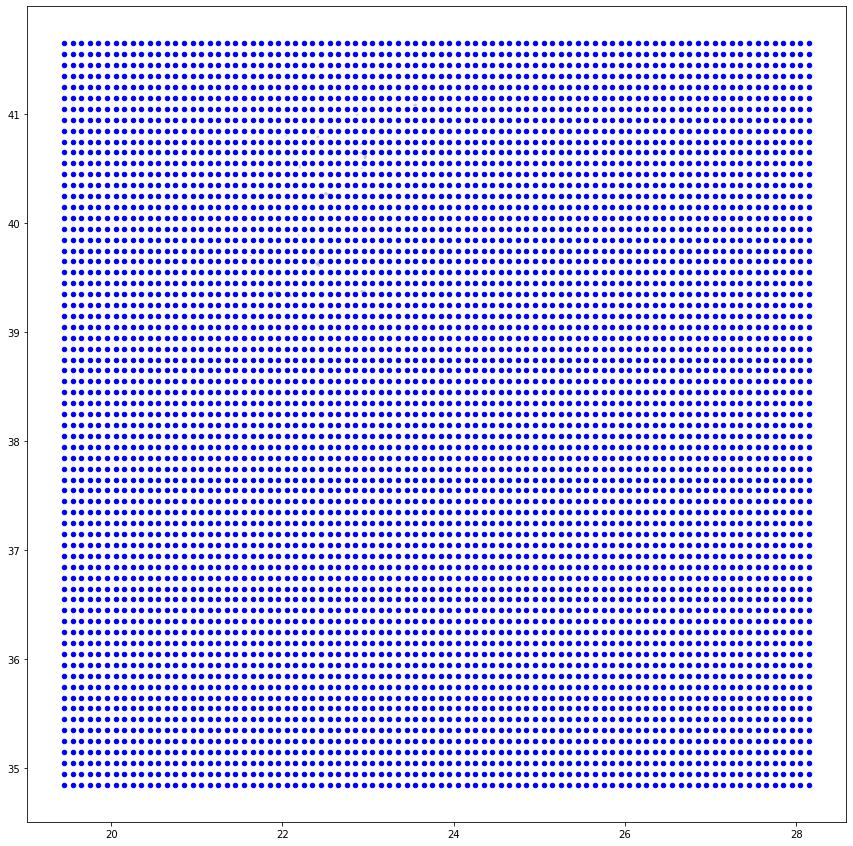

In [86]:
fig,ax = plt.subplots(figsize=(15,15))
shpFile.plot(ax=ax,alpha=0.4,color='grey')
geo_df.plot(ax=ax,markersize=20,color='blue',marker='o')
